In [ ]:
from pathlib import Path


#combined_enron = Path('combined_datasets') / 'combined_Enron.mbox' # Uncomment this line after generating the enron mbox file
combined_spam    = Path('combined_datasets') / 'combined_SpamAssasin.mbox'
phish0           = Path('datasets_original') / 'Phishing Nazario' / 'phishing0.mbox'
phish1           = Path('datasets_original') / 'Phishing Nazario' / 'phishing1.mbox'
phish2           = Path('datasets_original') / 'Phishing Nazario' / 'phishing2.mbox'
phish3           = Path('datasets_original') / 'Phishing Nazario' / 'phishing3.mbox'

all_mboxes = {
    #'enron' : combined_enron,
    'spam'  : combined_spam,
    'ph0'   : phish0,
    'ph1'   : phish1,
    'ph2'   : phish2,
    'ph3'   : phish3,

}

### EXTERNAL FEATURES

Feature 1: HTML Part Presence

**Source:** Fette et al. (2007) 

In [38]:
import mailbox
import pandas as pd

def extract_has_html(msg):
    # Return a dict with the has_html flag.
    return {
        'has_html': int(any(
            part.get_content_type() == 'text/html'
            for part in msg.walk()
        ))
    }

# Loop through all mboxes, extract the feature 
records = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_has_html(msg)
        feat['source'] = src
        records.append(feat)

# Build the DataFrame 
df = pd.DataFrame(records)
print(df['has_html'].value_counts(dropna=False))
df.head()

has_html
0    521636
1      4487
Name: count, dtype: int64


,has_html,source
0,0,enron
1,0,enron
2,0,enron
3,0,enron
4,0,enron



Feature 2: IP-based URLs

**Source:** Fette et al. (2007) 


In [39]:
import re
from urllib.parse import urlparse
import mailbox

ip_host_re = re.compile(r'^(?:\d{1,3}\.){3}\d{1,3}$')

def extract_has_ip_link(msg):
    #returns has_ip_link: 0 or 1 for the current message
    has_ip = 0
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if not payload:
                continue
            html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
            for href in re.findall(r'href=[\'"]([^\'"]+)', html, re.IGNORECASE):
                host = urlparse(href).hostname or ''
                if ip_host_re.fullmatch(host):
                    has_ip = 1
                    break
            if has_ip:
                break
    return {'has_ip_link': has_ip}


# Loop through all mboxes, call the function, collect flags
ip_flags = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_has_ip_link(msg)
        ip_flags.append(feat['has_ip_link'])

# Append to the DataFrame
df['has_ip_link'] = ip_flags

print(df['has_ip_link'].value_counts())
df[['source','has_ip_link']].head()

has_ip_link
0    524873
1      1250
Name: count, dtype: int64


,source,has_ip_link
0,enron,0
1,enron,0
2,enron,0
3,enron,0
4,enron,0


Feature 3: Non-matching URLs  

**Source:** Fette et al. (2007) 

In [40]:
import re
import mailbox
import bs4  
from urllib.parse import urlparse

urlish_re = re.compile(r'\bhttps?://|www\.|\.[a-z]{2,}$', re.I)

def extract_nonmatching_url(msg):
    # returns nonmatching_url: 0 or 1 for the current message
    flag = 0
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if not payload:
                continue
            html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
            soup = bs4.BeautifulSoup(html, 'html.parser')
            for a in soup.find_all('a', href=True):
                anchor_text = (a.get_text() or '').strip()
                if not urlish_re.search(anchor_text):
                    continue  # visible text it's not an url
                # parse hosts
                text_url = anchor_text if anchor_text.startswith(('http://','https://')) else 'http://' + anchor_text
                text_host = urlparse(text_url).hostname or ''
                href_host = urlparse(a['href']).hostname or ''
                if text_host and href_host and text_host.lower() != href_host.lower():
                    flag = 1
                    break
            if flag:
                break
    return {'nonmatching_url': flag}

# Loop through all mboxes, call the function, collect flags
nonmatch_flags = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_nonmatching_url(msg)
        nonmatch_flags.append(feat['nonmatching_url'])

# Append to the DataFrame
df['nonmatching_url'] = nonmatch_flags

print(df['nonmatching_url'].value_counts())
df[['source','nonmatching_url']].head()

nonmatching_url
0    523735
1      2388
Name: count, dtype: int64


,source,nonmatching_url
0,enron,0
1,enron,0
2,enron,0
3,enron,0
4,enron,0


Feature 4  “Here‑link off modal domain”

**Source** — Fette et al. (2007) 

In [41]:
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import mailbox

# Anchor texts to be tested
generic_texts = {
    "here",
    "click here",
    "click here",
    "click here.",
    "link",
    "this link",
}

def extract_here_off_domain(msg):
    # returns here_off_domain: 0 or 1 for the current message
    flag = 0
    modal_host = None
    host_counts = {}

    # Collect all HTML parts
    html_parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if payload:
                html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
                html_parts.append(html)

    # count hosts to find the most common domain
    for html in html_parts:
        soup = BeautifulSoup(html, 'html.parser')
        for a in soup.find_all('a', href=True):
            host = urlparse(a['href']).hostname or ''
            if host:
                host_counts[host.lower()] = host_counts.get(host.lower(), 0) + 1

    if host_counts:
        modal_host = max(host_counts.items(), key=lambda kv: kv[1])[0]

    # look for anchor text pointing off-domain
    if modal_host:
        for html in html_parts:
            soup = BeautifulSoup(html, 'html.parser')
            for a in soup.find_all('a', href=True):
                anchor_text = (a.get_text() or '').strip().lower()
                if anchor_text in generic_texts:
                    link_host = (urlparse(a['href']).hostname or '').lower()
                    if link_host and link_host != modal_host:
                        flag = 1
                        break
            if flag:
                break

    return {'here_off_domain': flag}


# Loop through all mboxes, call the function, collect flags
here_flags = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_here_off_domain(msg)
        here_flags.append(feat['here_off_domain'])

# Append to the DataFrame
df['here_off_domain'] = here_flags

print(df['here_off_domain'].value_counts())
df[['source','here_off_domain']].head()

here_off_domain
0    526007
1       116
Name: count, dtype: int64


,source,here_off_domain
0,enron,0
1,enron,0
2,enron,0
3,enron,0
4,enron,0


Feature 5: Number of URLs  

**Source:** Fette et al. (2007)   



In [42]:
from bs4 import BeautifulSoup
import mailbox

def extract_num_urls(msg):
    # Returns a dict with the number of <a href> tags in all HTML parts of the current message
    count = 0
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if not payload:
                continue
            html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
            soup = BeautifulSoup(html, 'html.parser')
            count += len(soup.find_all('a', href=True))
    return {'num_urls': count}

# Loop through all mboxes, call the function
url_counts = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_num_urls(msg)
        url_counts.append(feat['num_urls'])

# Append to the DataFrame
df['num_urls'] = url_counts

url_stats = df.groupby('source')['num_urls'].describe()
print("\nnum_urls by source:")
print(url_stats)


num_urls by source:
           count      mean        std  min  25%  50%  75%    max
source                                                          
enron   517401.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
ph0        414.0  4.072464   4.842764  0.0  2.0  3.0  5.0   31.0
ph1        456.0  3.532895   5.094601  0.0  1.0  2.0  4.0   51.0
ph2       1423.0  3.342937   4.456119  0.0  1.0  2.0  4.0   59.0
ph3       2279.0  3.408513   4.362859  0.0  1.0  1.0  4.0   27.0
spam      4150.0  1.986988  11.018065  0.0  0.0  0.0  0.0  117.0


Feature 6: Empty visible `<a>` text

**Source:** Sonowal (2020) 

In [43]:
import bs4
import mailbox

def extract_empty_anchor(msg):
    #returns  empty_anchor': 0 or 1 for the current message
    flag = 0
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if not payload:
                continue
            html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
            soup = bs4.BeautifulSoup(html, 'html.parser')
            for a in soup.find_all('a', href=True):
                if not a.get_text(strip=True):
                    flag = 1
                    break
            if flag:
                break
    return {'empty_anchor': flag}

# Loop through all mboxes, call the function, collect flags
empty_anchor_flags = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_empty_anchor(msg)
        empty_anchor_flags.append(feat['empty_anchor'])

# Append to the DataFrame
df['empty_anchor'] = empty_anchor_flags

print(df['empty_anchor'].value_counts())
df[['source','empty_anchor']].head()

empty_anchor
0    523852
1      2271
Name: count, dtype: int64


,source,empty_anchor
0,enron,0
1,enron,0
2,enron,0
3,enron,0
4,enron,0


Feature 7: Max “.” Count in Any Link  

**Source (Fette et al., 2007):**  


In [44]:
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import mailbox

def extract_max_dots(msg):
    # returns max_dots as an int for the current message
    max_dots = 0
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if not payload:
                continue
            html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
            soup = BeautifulSoup(html, 'html.parser')
            for a in soup.find_all('a', href=True):
                host = urlparse(a['href']).hostname or ''
                dots = host.count('.')
                if dots > max_dots:
                    max_dots = dots
    return {'max_dots': max_dots}

# Loop through all mboxes, call the function
max_dots_list = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_max_dots(msg)
        max_dots_list.append(feat['max_dots'])

# Append to the DataFrame
df['max_dots'] = max_dots_list

print("\nmax_dots by source:")
print(df.groupby('source')['max_dots'].describe())


max_dots by source:
           count      mean       std  min  25%  50%  75%   max
source                                                        
enron   517401.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
ph0        414.0  2.369565  0.878112  0.0  2.0  3.0  3.0   4.0
ph1        456.0  2.285088  1.356254  0.0  2.0  2.0  3.0  17.0
ph2       1423.0  2.402670  1.416765  0.0  2.0  2.0  3.0  17.0
ph3       2279.0  3.033348  1.557708  0.0  2.0  3.0  4.0  10.0
spam      4150.0  0.091807  0.442397  0.0  0.0  0.0  0.0   4.0


Feature 8: Unsubscribe link presence 

**Source:** Sonowal (2020) –  


In [45]:
import bs4 
import mailbox

def extract_has_unsubscribe(msg):
    #returns has_unsubscribe : 0 or 1 for the current message
    flag = 0
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if not payload:
                continue
            html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
            soup = bs4.BeautifulSoup(html, 'html.parser')
            for a in soup.find_all('a', href=True):
                text = (a.get_text(strip=True) or '').lower()
                href = a['href'].lower()
                if 'unsubscribe' in text or 'unsubscribe' in href:
                    flag = 1
                    break
            if flag:
                break
    return {'has_unsubscribe': flag}


# Loop through all mboxes, call the function
unsub_flags = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_has_unsubscribe(msg)
        unsub_flags.append(feat['has_unsubscribe'])

# Append to the DataFrame
df['has_unsubscribe'] = unsub_flags

print(df['has_unsubscribe'].value_counts())
df[['source','has_unsubscribe']].head()

has_unsubscribe
0    526014
1       109
Name: count, dtype: int64


,source,has_unsubscribe
0,enron,0
1,enron,0
2,enron,0
3,enron,0
4,enron,0


Feature 9: Image-based Links

**Source:** Yang et al. (2019) 

In [46]:
from bs4 import BeautifulSoup
import mailbox

def extract_has_image_link(msg):
    # Returns has_image_link: 0 or 1 for the current message
    flag = 0
    for part in msg.walk():
        if part.get_content_type() == 'text/html':
            payload = part.get_payload(decode=True)
            if not payload:
                continue
            html = payload.decode('utf-8', 'ignore') if isinstance(payload, bytes) else payload
            soup = BeautifulSoup(html, 'html.parser')
            # Look for <a> tags that contain an <img> 
            for a in soup.find_all('a', href=True):
                if a.find('img'):
                    flag = 1
                    break
            if flag:
                break
    return {'has_image_link': flag}


# Loop through all mboxes, call the function
image_link_flags = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_has_image_link(msg)
        image_link_flags.append(feat['has_image_link'])

# Append to the DataFrame
df['has_image_link'] = image_link_flags

print("Overall has_image_link distribution:")
print(df['has_image_link'].value_counts())
df[['source','has_image_link']].head()

Overall has_image_link distribution:
has_image_link
0    523942
1      2181
Name: count, dtype: int64


,source,has_image_link
0,enron,0
1,enron,0
2,enron,0
3,enron,0
4,enron,0


 Feature 10: Inconsistent Reply-To vs. From  

**Source (Yang et al., 2019):**  


In [47]:
from email.utils import parseaddr
import mailbox

def extract_reply_to_diff(msg):
    # returns reply_to_diff_from: 0 or 1 for the current message
    raw_from  = str(msg.get('From', '') or '')
    raw_reply = str(msg.get('Reply-To', '') or '')
    from_addr = parseaddr(raw_from)[1].lower()
    reply_to  = parseaddr(raw_reply)[1].lower()
    flag = int(bool(reply_to and (reply_to != from_addr)))
    return {'reply_to_diff_from': flag}

# Loop through all mboxes, call the function
reply_diff_flags = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_reply_to_diff(msg)
        reply_diff_flags.append(feat['reply_to_diff_from'])

# Append to the DataFrame
df['reply_to_diff_from'] = reply_diff_flags

print("Overall reply_to_diff_from distribution:")
print(df['reply_to_diff_from'].value_counts())
df[['source','reply_to_diff_from']].head()

Overall reply_to_diff_from distribution:
reply_to_diff_from
0    524594
1      1529
Name: count, dtype: int64


,source,reply_to_diff_from
0,enron,0
1,enron,0
2,enron,0
3,enron,0
4,enron,0


### INTERNAL FEATURES

## Step 1: Extract Raw Subject & Body Text

We’ll read each email `.mbox` and pull out:
- **Subject:** the message’s Subject header  
- **Body (raw):** the first `text/plain` part 

Store these fields (alongside your `source` label) into a  DataFrame for further extraction.


In [48]:
import mailbox
import pandas as pd

from bs4 import BeautifulSoup

def extract_text_features(msg):
    #Return subject: str and  body_raw: str for the current message
    #Falls back to stripping HTML if no text/plain part is found
    subject = msg.get('Subject', '') or ''

    # Try text/plain
    body_raw = ""
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            payload = part.get_payload(decode=True)
            if payload:
                body_raw = payload.decode('utf-8', 'ignore')
            break

    # Fallback: if still empty, grab the first text/html and strip tags
    if not body_raw:
        for part in msg.walk():
            if part.get_content_type() == 'text/html':
                payload = part.get_payload(decode=True)
                if not payload:
                    continue
                html = payload.decode('utf-8', 'ignore')
                # get only the text using bs
                soup = BeautifulSoup(html, 'html.parser')
                body_raw = soup.get_text(separator=' ', strip=True)
                break

    return {
        'subject':  subject,
        'body_raw': body_raw,
    }

# Loop through all mboxes
records = []
for src, mbox_path in all_mboxes.items():
    mbox = mailbox.mbox(mbox_path)
    for msg in mbox:
        feat = extract_text_features(msg)
        feat['source'] = src
        records.append(feat)

# Build the DataFrame 
df_text = pd.DataFrame(records)
df_text.head()

,subject,body_raw,source
0,Status,John:\n?\nI'm not really sure what happened be...,enron
1,re:summer inverses,i suck-hope youve made more money in natgas la...,enron
2,The WTI Bullet swap contracts,"Hi,\n\n\n Following the e-mail you have rece...",enron
3,Invitation: EBS/GSS Meeting w/Bristol Babcock ...,Conference Room TBD. \n\nThis meeting will be...,enron
4,Harvard Mgmt,Mike- I have their trader coming into the offi...,enron


**Step 2: Preprocessing & Tokenization**  

We’ll clean the raw body text by:
1. Lowercasing all characters  
2. Replacing punctuation with spaces  
3. Splitting on whitespace  

We’ll also load a standard English stop-word list.

In [49]:
import re
import string
import nltk

#Downlaod the stopword list
nltk.download('stopwords')

from nltk.corpus import stopwords
STOP = set(stopwords.words('english'))

def clean_and_tokenize(text):
    #  Lowercase
    txt = text.lower()
    # Replace all punctuation with spaces
    txt = re.sub(f"[{re.escape(string.punctuation)}]", " ", txt)
    #  Split on whitespace
    tokens = txt.split()
    return tokens

def apply_text_preprocessing(df, text_col='body_raw', tokens_col='tokens'):
    #Add a tokens column to df
    df[tokens_col] = df[text_col].apply(clean_and_tokenize)
    return df

# Apply to the DataFrame
df_text = apply_text_preprocessing(df_text)

print(df_text['tokens'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mateiteodoru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [john, i, m, not, really, sure, what, happened...
1    [i, suck, hope, youve, made, more, money, in, ...
2    [hi, following, the, e, mail, you, have, recei...
3    [conference, room, tbd, this, meeting, will, b...
4    [mike, i, have, their, trader, coming, into, t...
Name: tokens, dtype: object


# Feature 1: Word Count

We count the total number of tokens (words) in each email’s body.

### Source Egozi & Verma (2018)


In [50]:
def compute_word_count(tokens):
   #Returns the number of tokens.
    return len(tokens)

# Apply the function
df_text['word_count'] = df_text['tokens'].apply(compute_word_count)

print(df_text['word_count'].describe())

# Per‐source breakdown
grouped_stats = df_text.groupby('source')['word_count'].describe()
print(grouped_stats)

df_text[['source','word_count']].head()

count    526123.000000
mean        288.181167
std         923.180859
min           0.000000
25%          50.000000
50%         130.000000
75%         286.000000
max      191390.000000
Name: word_count, dtype: float64
           count        mean         std  min     25%    50%    75%       max
source                                                                       
enron   517401.0  288.699477  928.556540  0.0   50.00  129.0  286.0  191390.0
ph0        414.0  228.799517  165.768738  0.0  149.50  214.0  269.0    1225.0
ph1        456.0  240.412281  168.612023  0.0  154.75  243.0  282.5    1742.0
ph2       1423.0  209.711876  175.197313  0.0  124.00  185.0  262.0    2220.0
ph3       2279.0  232.054410  181.376433  0.0  135.00  200.0  318.0    2882.0
spam      4150.0  292.462410  715.076655  6.0   87.00  158.0  273.0   24688.0


,source,word_count
0,enron,110
1,enron,54
2,enron,175
3,enron,32
4,enron,142


# Feature 2: Stop-Word Ratio

We count how many of the tokens in each email are stop-words and divide by the total word count:

### Source Egozi & Verma (2018)


In [51]:
def compute_stop_word_count(tokens):
   #Returns the count of tokens that are stop words
    return sum(1 for w in tokens if w in STOP)

def compute_stop_word_ratio(row):
    #Returns stop-word ratio
    return (row['stop_word_count'] / row['word_count']) if row['word_count'] > 0 else 0

df_text['stop_word_count'] = df_text['tokens'].apply(compute_stop_word_count)
df_text['stop_word_ratio'] = df_text.apply(compute_stop_word_ratio, axis=1)

# Summary
print("Overall stop_word_ratio distribution:")
print(df_text['stop_word_ratio'].describe())

grouped_stats = df_text.groupby('source')['stop_word_ratio'].describe()
print(grouped_stats)

df_text[['source','stop_word_ratio']].head()

Overall stop_word_ratio distribution:
count    526123.000000
mean          0.341108
std           0.140108
min           0.000000
25%           0.259259
50%           0.358974
75%           0.435294
max           1.000000
Name: stop_word_ratio, dtype: float64
           count      mean       std  min       25%       50%       75%  \
source                                                                    
enron   517401.0  0.340990  0.140274  0.0  0.258621  0.358382  0.435294   
ph0        414.0  0.374867  0.088109  0.0  0.335710  0.403101  0.422727   
ph1        456.0  0.357061  0.143759  0.0  0.338583  0.410837  0.443439   
ph2       1423.0  0.369821  0.131401  0.0  0.370951  0.404624  0.437908   
ph3       2279.0  0.327951  0.157964  0.0  0.231862  0.384615  0.435564   
spam      4150.0  0.348091  0.110533  0.0  0.291139  0.365112  0.427490   

             max  
source            
enron   1.000000  
ph0     0.555556  
ph1     0.733333  
ph2     0.750000  
ph3     1.000000  
spam  

,source,stop_word_ratio
0,enron,0.536364
1,enron,0.351852
2,enron,0.245714
3,enron,0.343750
4,enron,0.535211


# Feature 3: Unique-Word Ratio

We count how many **distinct** tokens appear in each email, then divide by the total word count:
 
### Source Egozi & Verma (2018)


In [52]:
def compute_unique_word_count(tokens):
    #Return the number of distinct tokens
    return len(set(tokens))

def compute_unique_word_ratio(row):
   #Return unique_word_count / word_count, or 0 if word_count is zero
    return (row['unique_word_count'] / row['word_count']) if row['word_count'] > 0 else 0

df_text['unique_word_count'] = df_text['tokens'].apply(compute_unique_word_count)
df_text['unique_word_ratio'] = df_text.apply(compute_unique_word_ratio, axis=1)

print(df_text['unique_word_ratio'].describe())

grouped_stats = df_text.groupby('source')['unique_word_ratio'].describe()
print(grouped_stats)

df_text[['source','unique_word_ratio']].head()

count    526123.000000
mean          0.680392
std           0.188794
min           0.000000
25%           0.538462
50%           0.672131
75%           0.828571
max           1.000000
Name: unique_word_ratio, dtype: float64
           count      mean       std       min       25%       50%       75%  \
source                                                                         
enron   517401.0  0.680995  0.189146  0.000000  0.538275  0.672897  0.830189   
ph0        414.0  0.634009  0.140359  0.000000  0.564489  0.590909  0.717391   
ph1        456.0  0.589013  0.160981  0.000000  0.505776  0.572776  0.628571   
ph2       1423.0  0.583173  0.169184  0.000000  0.528689  0.585492  0.644444   
ph3       2279.0  0.620135  0.167247  0.000000  0.537906  0.614907  0.729289   
spam      4150.0  0.686230  0.148095  0.099434  0.589119  0.689486  0.782609   

        max  
source       
enron   1.0  
ph0     1.0  
ph1     1.0  
ph2     1.0  
ph3     1.0  
spam    1.0  


,source,unique_word_ratio
0,enron,0.809091
1,enron,0.833333
2,enron,0.560000
3,enron,0.906250
4,enron,0.647887


# Feature 4: Unique-Stop-Word Ratio

We count how many **distinct** stop-words appear in each email’s token list, then divide by the **total** stop-word count:

### Source Egozi & Verma (2018)

In [53]:
def compute_unique_stop_word_count(tokens):
   # Return the number of distinct stop-words.
    return len(set(tokens) & STOP)

def compute_unique_stop_word_ratio(unique_count, stop_word_count):
    # Return the ratio of unique stop-words to total stop-words, or 0 if stop_word_count is zero
    return unique_count / stop_word_count if stop_word_count > 0 else 0

df_text['unique_stop_word_count'] = df_text['tokens'].apply(compute_unique_stop_word_count)
df_text['unique_stop_word_ratio'] = df_text.apply(
    lambda row: compute_unique_stop_word_ratio(
        row['unique_stop_word_count'],
        row['stop_word_count']
    ),
    axis=1
)

print(df_text['unique_stop_word_ratio'].describe())
grouped_stats = df_text.groupby('source')['unique_stop_word_ratio'].describe()
print(grouped_stats)

df_text[['source','unique_stop_word_ratio']].head()

count    526123.000000
mean          0.556799
std           0.260272
min           0.000000
25%           0.363636
50%           0.543478
75%           0.750000
max           1.000000
Name: unique_stop_word_ratio, dtype: float64
           count      mean       std  min       25%       50%       75%  max
source                                                                      
enron   517401.0  0.558048  0.260842  0.0  0.364341  0.545455  0.750000  1.0
ph0        414.0  0.464568  0.179078  0.0  0.364784  0.409091  0.545455  1.0
ph1        456.0  0.386067  0.184419  0.0  0.314080  0.355769  0.462687  1.0
ph2       1423.0  0.408666  0.178757  0.0  0.325926  0.394366  0.491933  1.0
ph3       2279.0  0.436514  0.179860  0.0  0.344841  0.421687  0.507463  1.0
spam      4150.0  0.545887  0.223291  0.0  0.397849  0.535047  0.690476  1.0


,source,unique_stop_word_ratio
0,enron,0.677966
1,enron,0.684211
2,enron,0.441860
3,enron,0.727273
4,enron,0.486842


# Feature 5: Punctuation Ratio

We count all punctuation characters in the raw email body and divide by the total word count:

### Source Egozi & Verma (2018)


In [54]:
import string

def compute_punctuation_count(text):
    #Count how many characters in `text` are punctuation
    return sum(1 for ch in text if ch in string.punctuation)

def compute_punctuation_ratio(punct_count, word_count):
    return (punct_count / word_count) if word_count > 0 else 0

df_text['punctuation_count'] = df_text['body_raw'].apply(compute_punctuation_count)
df_text['punctuation_ratio'] = df_text.apply(
    lambda row: compute_punctuation_ratio(row['punctuation_count'], row['word_count']),
    axis=1
)

# Summary
grouped_stats = df_text.groupby('source')['punctuation_ratio'].describe()
print(grouped_stats)

df_text[['source','punctuation_ratio']].head()

           count      mean       std       min       25%       50%       75%  \
source                                                                         
enron   517401.0  0.453043  0.488797  0.000000  0.200000  0.333333  0.584158   
ph0        414.0  0.261908  0.246618  0.000000  0.164835  0.176923  0.207322   
ph1        456.0  0.319263  0.417268  0.000000  0.145985  0.167344  0.219858   
ph2       1423.0  0.283638  0.415560  0.000000  0.138158  0.172727  0.234436   
ph3       2279.0  0.343584  0.329660  0.000000  0.151921  0.201835  0.359503   
spam      4150.0  0.675278  0.451562  0.052632  0.355035  0.534483  0.871703   

              max  
source             
enron   37.000000  
ph0      1.447942  
ph1      1.863636  
ph2      6.830769  
ph3      2.448276  
spam     4.142857  


,source,punctuation_ratio
0,enron,0.336364
1,enron,0.148148
2,enron,0.274286
3,enron,0.187500
4,enron,0.161972


# Feature 6: Unique-Punctuation Ratio

We count how many **distinct** punctuation characters appear in each email’s raw body text, then divide by the total word count:

### Source Egozi & Verma (2018)

In [55]:
import string

def compute_unique_punctuation_count(text):
    #Return the number of distinct punctuation characters
    return len({ch for ch in text if ch in string.punctuation})

def compute_unique_punctuation_ratio(count, word_count):
    return (count / word_count) if word_count > 0 else 0

df_text['unique_punctuation_count'] = df_text['body_raw'].apply(
    compute_unique_punctuation_count
)
df_text['unique_punctuation_ratio'] = df_text.apply(
    lambda row: compute_unique_punctuation_ratio(
        row['unique_punctuation_count'],
        row['word_count']
    ),
    axis=1
)

# Summary
print(df_text['unique_punctuation_ratio'].describe())
grouped_stats = df_text.groupby('source')['unique_punctuation_ratio'].describe()
print(grouped_stats)

df_text[['source','unique_punctuation_ratio']].head()

count    526123.000000
mean          0.082988
std           0.095737
min           0.000000
25%           0.032823
50%           0.056604
75%           0.100000
max           4.000000
Name: unique_punctuation_ratio, dtype: float64
           count      mean       std       min       25%       50%       75%  \
source                                                                         
enron   517401.0  0.083217  0.096096  0.000000  0.032847  0.056872  0.100000   
ph0        414.0  0.052021  0.067340  0.000000  0.033898  0.040909  0.051613   
ph1        456.0  0.039831  0.028607  0.000000  0.027267  0.036290  0.046784   
ph2       1423.0  0.050088  0.085453  0.000000  0.029661  0.037975  0.053030   
ph3       2279.0  0.039934  0.029083  0.000000  0.023673  0.034667  0.048128   
spam      4150.0  0.097160  0.072643  0.001175  0.049721  0.080357  0.124031   

             max  
source            
enron   4.000000  
ph0     1.250000  
ph1     0.333333  
ph2     2.000000  
ph3     0.4000

,source,unique_punctuation_ratio
0,enron,0.072727
1,enron,0.055556
2,enron,0.062857
3,enron,0.156250
4,enron,0.049296


# Feature 7: Stop-Word to Unique-Word Ratio

We take the total number of stop-words in each email and divide by the number of **distinct** words:

### Source Egozi & Verma (2018)

In [56]:
def compute_stop_to_unique_ratio(row):
    # Returns the ratio of stop-word count to unique-word count, or 0 if there are no unique words
    unique = row['unique_word_count']
    return row['stop_word_count'] / unique if unique > 0 else 0

df_text['stop_to_unique_word_ratio'] = df_text.apply(compute_stop_to_unique_ratio, axis=1)

print(df_text['stop_to_unique_word_ratio'].describe())
grouped_stats = df_text.groupby('source')['stop_to_unique_word_ratio'].describe()
print(grouped_stats)
df_text[['source','stop_to_unique_word_ratio']].head()

count    526123.000000
mean          0.545483
std           0.293897
min           0.000000
25%           0.375000
50%           0.541176
75%           0.698020
max          10.777778
Name: stop_to_unique_word_ratio, dtype: float64
           count      mean       std  min       25%       50%       75%  \
source                                                                    
enron   517401.0  0.545082  0.294410  0.0  0.375000  0.540000  0.697183   
ph0        414.0  0.621008  0.193102  0.0  0.497808  0.649123  0.717949   
ph1        456.0  0.634076  0.259211  0.0  0.531250  0.721088  0.802548   
ph2       1423.0  0.636550  0.265769  0.0  0.573325  0.693069  0.766917   
ph3       2279.0  0.547887  0.284207  0.0  0.377713  0.644444  0.739130   
spam      4150.0  0.545661  0.244974  0.0  0.402891  0.536157  0.674855   

              max  
source             
enron   10.777778  
ph0      1.157706  
ph1      1.023256  
ph2      3.215686  
ph3      2.555556  
spam     4.180217  


,source,stop_to_unique_word_ratio
0,enron,0.662921
1,enron,0.422222
2,enron,0.438776
3,enron,0.379310
4,enron,0.826087


# Feature 8: Punctuation to Unique-Word Ratio

We divide the total number of punctuation characters in the raw email body by the number of **distinct** words:

### Soruce Egozi & Verma (2018)


In [57]:
def compute_punct_to_unique_word_ratio(row):
   #Return punctuation_count / unique_word_count, or 0 if unique_word_count is zero
    return (row['punctuation_count'] / row['unique_word_count']) \
           if row['unique_word_count'] > 0 else 0

df_text['punct_to_unique_word_ratio'] = df_text.apply(
    compute_punct_to_unique_word_ratio,
    axis=1
)

#Summary
print(df_text['punct_to_unique_word_ratio'].describe())

grouped_stats = df_text.groupby('source')['punct_to_unique_word_ratio'].describe()
print(grouped_stats)

df_text[['source','punct_to_unique_word_ratio']].head()

count    526123.000000
mean          0.784447
std           3.500401
min           0.000000
25%           0.277778
50%           0.511834
75%           0.989899
max        1267.000000
Name: punct_to_unique_word_ratio, dtype: float64
           count      mean       std       min       25%       50%       75%  \
source                                                                         
enron   517401.0  0.784574  3.527779  0.000000  0.277108  0.512000  0.989899   
ph0        414.0  0.451580  0.512209  0.000000  0.255489  0.292308  0.349462   
ph1        456.0  0.655672  1.079090  0.000000  0.253731  0.296663  0.383021   
ph2       1423.0  0.516467  1.300191  0.000000  0.229433  0.298387  0.391435   
ph3       2279.0  0.559383  0.662323  0.000000  0.249260  0.330275  0.604480   
spam      4150.0  1.031529  0.813571  0.055556  0.518316  0.763444  1.306704   

                max  
source               
enron   1267.000000  
ph0        3.139535  
ph1        4.986486  
ph2       39.469

,source,punct_to_unique_word_ratio
0,enron,0.415730
1,enron,0.177778
2,enron,0.489796
3,enron,0.206897
4,enron,0.250000


# Feature 9: Title Blacklist Terms

We scan each email’s subject line for common phishing trigger words (e.g. “account”, “password”, “urgent”) and record whether any appear and how many times.

### Source Yang et al. (2019)


In [58]:
# Define the set of trigger words
title_terms = {"account", "password", "urgent", "verify", "login"}

def compute_title_flag(subject):
    #Returns 1 if any trigger word is present in the subject, else 0
    subj = str(subject).lower()
    return int(any(term in subj for term in title_terms))

def compute_title_count(subject):
    #Returns the total count of trigger-word occurrences in the subject
    subj = str(subject).lower()
    return sum(subj.count(term) for term in title_terms)

df_text['title_flag']  = df_text['subject'].apply(compute_title_flag)
df_text['title_count'] = df_text['subject'].apply(compute_title_count)

print(df_text[['source','subject','title_flag']].head())

  source                                            subject  title_flag
0  enron                                             Status           0
1  enron                                 re:summer inverses           0
2  enron                      The WTI Bullet swap contracts           0
3  enron  Invitation: EBS/GSS Meeting w/Bristol Babcock ...           0
4  enron                                       Harvard Mgmt           0


# Feature 10: Psychological Cue Ratio

We count words from a “fear/urgency” lexicon in each email body and divide by total word count:

### Source Yang et al. (2019)


In [59]:
# Define lexicon of urgency/fear words
psych_lexicon = {
    "urgent", "immediately", "threat", "suspend", "verify",
    "important", "attention", "risk", "alert"
}

def compute_psych_cue_count(tokens, lexicon=psych_lexicon):
    #Return how many tokens appear in the lexicon
    return sum(1 for w in tokens if w in lexicon)

def compute_psych_cue_ratio(count, total_words):
    #Return ratio of psych cues to total words (0 if no words)
    return (count / total_words) if total_words > 0 else 0

df_text['psych_cue_count'] = df_text['tokens'].apply(compute_psych_cue_count)
df_text['psych_cue_ratio'] = df_text.apply(
    lambda row: compute_psych_cue_ratio(row['psych_cue_count'], row['word_count']),
    axis=1
)

print(df_text[['source','psych_cue_count','psych_cue_ratio']].head())

  source  psych_cue_count  psych_cue_ratio
0  enron                0              0.0
1  enron                0              0.0
2  enron                0              0.0
3  enron                0              0.0
4  enron                0              0.0


### Combine feature tables & create the target label  

*We must put every feature into one table and add a binary target column (`is_phish`).*  

| `source` value | Meaning | `is_phish` |
|----------------|---------|-----------|
| `enron` & `spam` | legitimate (“ham”) | **0** |
| `ph0` – `ph3` | phishing | **1** |


In [60]:
import pandas as pd

# Remove 'source' in the second table before the concat
text_feats = df_text.drop(columns=['subject', 'body_raw', 'tokens', 'source'])

full_df = pd.concat(
    [df.reset_index(drop=True), text_feats.reset_index(drop=True)],
    axis=1
)

# Binary label
PHISH_SOURCES = {'ph0', 'ph1', 'ph2', 'ph3'}
full_df['is_phish'] = full_df['source'].map(
    lambda s: 1 if s in PHISH_SOURCES else 0
)

print(full_df[['source', 'is_phish']].head())
print("Shape:", full_df.shape)
print(full_df['is_phish'].value_counts())

print(full_df.groupby('source')['is_phish'].unique())

# Undersample ham for class balance
HAM_TARGET = 10000  # can be adjusted as needed

ham_df = full_df[full_df['is_phish'] == 0].sample(n=HAM_TARGET, random_state=42)
phish_df = full_df[full_df['is_phish'] == 1]

full_df = pd.concat([ham_df, phish_df]).reset_index(drop=True)

print("New label distribution:\n", full_df['is_phish'].value_counts())

  source  is_phish
0  enron         0
1  enron         0
2  enron         0
3  enron         0
4  enron         0
Shape: (526123, 29)
is_phish
0    521551
1      4572
Name: count, dtype: int64
source
enron    [0]
ph0      [1]
ph1      [1]
ph2      [1]
ph3      [1]
spam     [0]
Name: is_phish, dtype: object
New label distribution:
 is_phish
0    10000
1     4572
Name: count, dtype: int64


### 2 Select feature columns & handle missing values  


In [61]:
#Build X and y
FEATURE_COLS = [
    col for col in full_df.columns
    if col not in ['source', 'is_phish']   # drop metadata
]

FEATURE_COLS = [
    col for col in FEATURE_COLS
    if not (col.endswith('_count') and col != 'word_count')
]

X = full_df[FEATURE_COLS].copy()
y = full_df['is_phish'].values

print("Feature matrix shape:", X.shape)

print("Label distribution:\n", pd.Series(y).value_counts())  # count of 0s and 1s

Feature matrix shape: (14572, 20)
Label distribution:
 0    10000
1     4572
Name: count, dtype: int64


### 3 Train / test split  


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Training set:", X_train.shape, "  Test set:", X_test.shape)

Training set: (11657, 20)   Test set: (2915, 20)


### 4 Build SVM pipeline  


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm_clf = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('svc',   LinearSVC(C=0.5,class_weight={0:1, 1:0.75},
                        max_iter=10_000, random_state=42))
])

%time svm_clf.fit(X_train, y_train)

CPU times: user 37.9 ms, sys: 4.84 ms, total: 42.7 ms
Wall time: 46.5 ms


Pipeline(steps=[('scale', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.5, class_weight={0: 1, 1: 0.75}, max_iter=10000,
                           random_state=42))])

### 5 Evaluate on the test set  


              precision    recall  f1-score   support

           0      0.985     1.000     0.992      2000
           1      0.999     0.967     0.983       915

    accuracy                          0.989      2915
   macro avg      0.992     0.983     0.988      2915
weighted avg      0.990     0.989     0.989      2915



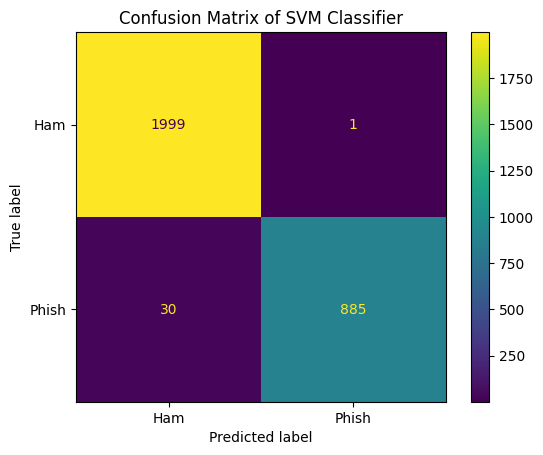

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = svm_clf.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham','Phish'])
disp.plot()
plt.title("Confusion Matrix of SVM Classifier")
plt.show()

### 9 Save the trained model  

*File produced*: `linear_svm_email_phishing.joblib`

In [65]:
import joblib
joblib.dump(svm_clf, "linear_svm_email_phishing.joblib")
joblib.dump(FEATURE_COLS, "feature_columns.joblib")
print("Model saved to linear_svm_email_phishing.joblib")

Model saved to linear_svm_email_phishing.joblib


### Prepare new Dataframe for prediction

In [66]:
# Load messages from Phish and Ham folders 
from pathlib import Path
import mailbox
import pandas as pd

# label 1 = phish, 0 = ham
mbox_sources = [
    (Path("AI-generated-phishing") / "generated-phish", 1),
    (Path("AI-generated-HAM")      / "generated-ham",   0),
]

msgs, filenames, true_labels, skipped = [], [], [], 0

for mbox_dir, label in mbox_sources:
    for mbox_path in sorted(mbox_dir.glob("*.mbox")):
        mb = mailbox.mbox(mbox_path)

        # Skip files that contain no messages
        if len(mb) == 0:
            skipped += 1
            #mbox_path.unlink()  # ← uncomment to delete instead of just skip
            print(f"🗑️  skipped empty file: {mbox_path.name}")
            mb.close()
            continue

        # Try to grab the message; on any error, skip the file
        try:
            msgs.append(mb[0])
            filenames.append(mbox_path.name)
            true_labels.append(label) 
        except Exception as e:
            skipped += 1
            print(f"⏭️  skipped malformed file {mbox_path.name}: {e}")
        finally:
            mb.close()

print(f"\nLoaded {len(msgs)} messages from {len(filenames)} files")
print(f"Skipped {skipped} empty or malformed .mbox files")

# Create dataframe, including true label
df_new = pd.DataFrame({
    "filename":      filenames,
    "true_is_phish": true_labels,
})


Loaded 2620 messages from 2620 files
Skipped 0 empty or malformed .mbox files


### Extract external features from the AI emails

In [67]:
# Feature extraction for LLM generated emails (features 1–10)
df_new['has_html']             = [extract_has_html(msg)['has_html']                       for msg in msgs]
df_new['has_ip_link']          = [extract_has_ip_link(msg)['has_ip_link']                 for msg in msgs]
df_new['nonmatching_url']      = [extract_nonmatching_url(msg)['nonmatching_url']         for msg in msgs]
df_new['here_off_domain']      = [extract_here_off_domain(msg)['here_off_domain']         for msg in msgs]
df_new['num_urls']             = [extract_num_urls(msg)['num_urls']                       for msg in msgs]
df_new['empty_anchor']         = [extract_empty_anchor(msg)['empty_anchor']               for msg in msgs]
df_new['max_dots']             = [extract_max_dots(msg)['max_dots']                       for msg in msgs]
df_new['has_unsubscribe']      = [extract_has_unsubscribe(msg)['has_unsubscribe']         for msg in msgs]
df_new['has_image_link']       = [extract_has_image_link(msg)['has_image_link']           for msg in msgs]
df_new['reply_to_diff_from']   = [extract_reply_to_diff(msg)['reply_to_diff_from']       for msg in msgs]

df_new.head()

,filename,true_is_phish,has_html,has_ip_link,nonmatching_url,here_off_domain,num_urls,empty_anchor,max_dots,has_unsubscribe,has_image_link,reply_to_diff_from
0,phish_0001.mbox,1,1,1,0,0,1,1,3,0,0,0
1,phish_0003.mbox,1,1,1,0,0,3,1,3,0,1,0
2,phish_0004.mbox,1,1,0,0,0,1,1,1,0,1,1
3,phish_0005.mbox,1,1,1,0,0,4,1,3,0,0,1
4,phish_0006.mbox,1,1,1,0,0,4,1,3,0,1,1


### Preprocess the LLM generated emails

In [68]:
import pandas as pd

text_feats = [extract_text_features(msg) for msg in msgs]

df_text_new = pd.DataFrame(text_feats)
df_text_new['filename'] = filenames

df_text_new.head()

,subject,body_raw,filename
0,Urgent: Account Security Alert,"Dear User,\n\nIt is crucial to confirm your ac...",phish_0001.mbox
1,Urgent: Action Required to Secure Your Amazon ...,"Dear Amazon Customer,\n\nWe have detected susp...",phish_0003.mbox
2,Urgent: Action Required to Secure Your Account,"Dear User,\n\nWe have detected an **unusual si...",phish_0004.mbox
3,Urgent: You're eligible for a ���100 Gift Card!,Congratulations! You're eligible for a €100 gi...,phish_0005.mbox
4,Notification: Tax Refund Urgent Processing Req...,"Dear Customer, You have a pending tax refund o...",phish_0006.mbox


In [69]:
df_text_new = apply_text_preprocessing(df_text_new, text_col='body_raw', tokens_col='tokens')

print(df_text_new[['filename','tokens']].head())

          filename                                             tokens
0  phish_0001.mbox  [dear, user, it, is, crucial, to, confirm, you...
1  phish_0003.mbox  [dear, amazon, customer, we, have, detected, s...
2  phish_0004.mbox  [dear, user, we, have, detected, an, unusual, ...
3  phish_0005.mbox  [congratulations, you, re, eligible, for, a, €...
4  phish_0006.mbox  [dear, customer, you, have, a, pending, tax, r...


### Extract internal features from AI emails

In [70]:
# Extract internal features from the LLM generated emails

df_text_new['word_count']                    = df_text_new['tokens'].apply(compute_word_count)
df_text_new['stop_word_count']               = df_text_new['tokens'].apply(compute_stop_word_count)
df_text_new['stop_word_ratio']               = df_text_new.apply(compute_stop_word_ratio, axis=1)
df_text_new['unique_word_count']             = df_text_new['tokens'].apply(compute_unique_word_count)
df_text_new['unique_word_ratio']             = df_text_new.apply(compute_unique_word_ratio, axis=1)
df_text_new['unique_stop_word_count']        = df_text_new['tokens'].apply(compute_unique_stop_word_count)
df_text_new['unique_stop_word_ratio']        = df_text_new.apply(
    lambda row: compute_unique_stop_word_ratio(
        row['unique_stop_word_count'],
        row['stop_word_count']
    ),
    axis=1
)
df_text_new['punctuation_count']             = df_text_new['body_raw'].apply(compute_punctuation_count)
df_text_new['punctuation_ratio']             = df_text_new.apply(
    lambda row: compute_punctuation_ratio(
        row['punctuation_count'],
        row['word_count']
    ),
    axis=1
)
df_text_new['unique_punctuation_count']      = df_text_new['body_raw'].apply(compute_unique_punctuation_count)
df_text_new['unique_punctuation_ratio']      = df_text_new.apply(
    lambda row: compute_unique_punctuation_ratio(
        row['unique_punctuation_count'],
        row['word_count']
    ),
    axis=1
)
df_text_new['stop_to_unique_word_ratio']     = df_text_new.apply(compute_stop_to_unique_ratio, axis=1)
df_text_new['punct_to_unique_word_ratio']    = df_text_new.apply(compute_punct_to_unique_word_ratio, axis=1)
df_text_new['title_flag']                    = df_text_new['subject'].apply(compute_title_flag)
df_text_new['title_count']                   = df_text_new['subject'].apply(compute_title_count)
df_text_new['psych_cue_count']               = df_text_new['tokens'].apply(compute_psych_cue_count)
df_text_new['psych_cue_ratio']               = df_text_new.apply(
    lambda row: compute_psych_cue_ratio(row['psych_cue_count'], row['word_count']),
    axis=1
)

df_text_new[[
    'filename',
    'word_count',
    'stop_word_ratio',
    'unique_word_ratio',
    'unique_stop_word_ratio',
    'punctuation_ratio',
    'unique_punctuation_ratio',
    'stop_to_unique_word_ratio',
    'punct_to_unique_word_ratio',
    'title_flag',
    'psych_cue_ratio'
]].head()

,filename,word_count,stop_word_ratio,unique_word_ratio,unique_stop_word_ratio,punctuation_ratio,unique_punctuation_ratio,stop_to_unique_word_ratio,punct_to_unique_word_ratio,title_flag,psych_cue_ratio
0,phish_0001.mbox,45,0.266667,0.822222,0.583333,0.266667,0.111111,0.324324,0.324324,1,0.022222
1,phish_0003.mbox,59,0.338983,0.762712,0.600000,0.220339,0.084746,0.444444,0.288889,1,0.033898
2,phish_0004.mbox,69,0.405797,0.681159,0.571429,0.362319,0.086957,0.595745,0.531915,1,0.057971
3,phish_0005.mbox,17,0.470588,1.000000,1.000000,0.235294,0.176471,0.470588,0.235294,1,0.000000
4,phish_0006.mbox,58,0.431034,0.810345,0.720000,0.224138,0.068966,0.531915,0.276596,1,0.017241


### Combine feature tables & predict new emails

In [71]:
import pandas as pd
import joblib

# Load the trained pipeline and feature list
svm_clf     = joblib.load("linear_svm_email_phishing.joblib")
FEATURE_COLS = joblib.load("feature_columns.joblib")

# drop non‐feature columns
text_feats_new = df_text_new.drop(columns=['filename', 'subject', 'body_raw', 'tokens'])

# concatenate the two tables
full_new = pd.concat(
    [df_new.reset_index(drop=True), text_feats_new.reset_index(drop=True)],
    axis=1
)

# Build feature matrix
X_new = full_new[FEATURE_COLS].copy()
X_new = X_new.fillna(0)

# Predict 
full_new['predicted_is_phish'] = svm_clf.predict(X_new)

# Show predictions
print(full_new[['filename', 'predicted_is_phish']])

# Save predictions to CSV
pred_df = full_new[['filename', 'predicted_is_phish']]
pred_df.to_csv("predicted_labels.csv", index=False)
print(f"Wrote {len(pred_df)} rows to predicted_labels.csv")

             filename  predicted_is_phish
0     phish_0001.mbox                   1
1     phish_0003.mbox                   1
2     phish_0004.mbox                   1
3     phish_0005.mbox                   1
4     phish_0006.mbox                   1
...               ...                 ...
2615    HAM_0996.mbox                   0
2616    HAM_0997.mbox                   0
2617    HAM_0998.mbox                   0
2618    HAM_0999.mbox                   0
2619    HAM_1000.mbox                   0

[2620 rows x 2 columns]
Wrote 2620 rows to predicted_labels.csv


### Results

              precision    recall  f1-score   support

         Ham      0.991     0.999     0.995      1000
       Phish      0.999     0.994     0.997      1620

    accuracy                          0.996      2620
   macro avg      0.995     0.997     0.996      2620
weighted avg      0.996     0.996     0.996      2620



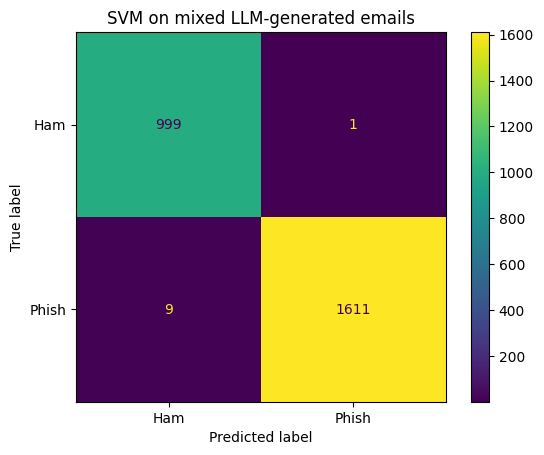

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true_new = full_new['true_is_phish'].values     # <── real labels
y_pred_new = full_new['predicted_is_phish'].values

print(classification_report(
        y_true_new, y_pred_new, digits=3,
        target_names=['Ham','Phish']))

cm = confusion_matrix(y_true_new, y_pred_new, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=['Ham','Phish']).plot()
plt.title("SVM on mixed LLM-generated emails")
plt.show()